# DeepSensor Quickstart

This notebook demonstrates how to use DeepSensor to train a ConvNP model to spatially interpolate ERA5 air temperature data over North America and use the trained model predict air temperature at arbitrary locations.

In [1]:
import deepsensor.torch
from deepsensor.data.loader import TaskLoader
from deepsensor.data.processor import DataProcessor
from deepsensor.model.convnp import ConvNP
from deepsensor.active_learning.algorithms import GreedyAlgorithm
from deepsensor.active_learning.acquisition_fns import Stddev

from deepsensor.train.train import train_epoch, set_gpu_default_device
from deepsensor.data.utils import construct_x1x2_ds

import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns

/home/tomand/miniconda3/envs/deepsensorgallery/lib/python3.11/site-packages/fdm/fdm.py:38: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coefs = mat.inv()[:, deriv] * np.math.factorial(deriv)
/home/tomand/miniconda3/envs/deepsensorgallery/lib/python3.11/site-packages/fdm/fdm.py:44: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  / np.math.factorial(order)
/home/tomand/miniconda3/envs/deepsensorgallery/lib/python3.11/site-packages/fdm/fdm.py:38: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coefs = mat.inv()[:, deriv] * np.math.factorial(deriv)
/home/tomand/miniconda3/envs/deepsensorgallery/lib/python3.11/site-packages/fdm/fdm.py:44: DeprecationWarning: `np.m

In [19]:
crs = ccrs.PlateCarree()

use_gpu = False
if use_gpu:
    set_gpu_default_device()

## Load raw data

In [20]:
# Load raw data
ds_raw = xr.tutorial.open_dataset("air_temperature")

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...


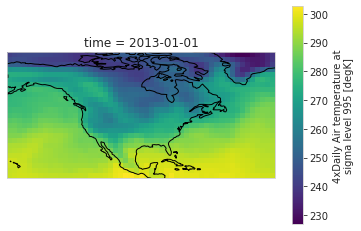

In [21]:
print(ds_raw)
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=crs))
ds_raw.isel(time=0).air.plot()
ax.coastlines()

## Normalise/preprocess data

In [5]:
data_processor = DataProcessor(x1_name="lat", x1_map=(ds_raw["lat"].min(), ds_raw["lat"].max()), x2_name="lon", x2_map=(ds_raw["lon"].min(), ds_raw["lon"].max()))
ds = data_processor(ds_raw)

In [6]:
# Generate auxiliary dataset of x1/x2 coordinates to break translation equivariance in the model's CNN
# to enable learning non-stationarity
x1x2_ds = construct_x1x2_ds(ds)
ds['x1_arr'] = x1x2_ds['x1_arr']
ds['x2_arr'] = x1x2_ds['x2_arr']
aux_ds = ds[['x1_arr', 'x2_arr']]
ds = ds[['air']]

## Set up TaskLoader

In [7]:
task_loader = TaskLoader(context=ds, target=ds)

## Set up ConvNP model

In [50]:
model = ConvNP(data_processor, task_loader, unet_channels=(32,)*8)

dim_yc inferred from TaskLoader: (1,)
dim_yt inferred from TaskLoader: 1
points_per_unit inferred from TaskLoader: 39
encoder_scales inferred from TaskLoader: [0.015224358066916466]
decoder_scale inferred from TaskLoader: 0.02564102564102564


## Generate training tasks

In [51]:
train_tasks = []
for date in pd.date_range("2013-01-01", "2014-11-30")[::7]:
    # Pass up to 10% of grid cells as context and use all grid cells as targets
    task = task_loader(date, context_sampling=np.random.uniform(0.0, 0.1), target_sampling="all")
    train_tasks.append(task)

## Train model

In [53]:
from tqdm import tqdm

n_epochs = 20
losses = []
for epoch in tqdm(range(n_epochs)):
    batch_losses = train_epoch(model, train_tasks)
    losses.append(np.mean(batch_losses))

100%|██████████| 20/20 [06:06<00:00, 18.31s/it]


Text(0, 0.5, 'Loss')

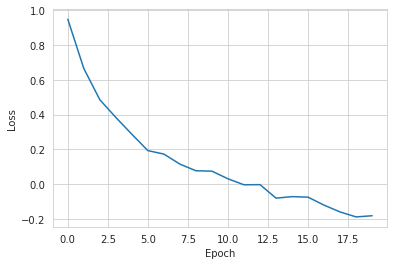

In [54]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

## Perform inference on unseen data

### Targets on a grid: Predict directly to xarray

In [55]:
# Predict on new task with 40 random grid cells passed as context
test_task = task_loader("2014-12-31", 40)
mean_ds, std_ds = model.predict(test_task, X_t=ds_raw)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<xarray.Dataset>
Dimensions:  (time: 1, lat: 25, lon: 53)
Coordinates:
  * time     (time) datetime64[ns] 2014-12-31
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
Data variables:
    air      (time, lat, lon) float32 262.0 261.7 261.3 ... 298.2 298.0 297.7


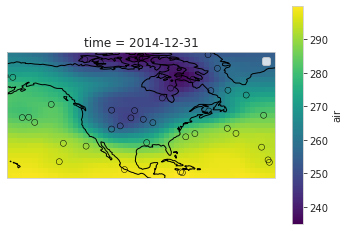

In [56]:
print(mean_ds)
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=crs))
mean_ds.isel(time=0).air.plot(ax=ax)
ax.coastlines()
deepsensor.plot.offgrid_context(ax, test_task, data_processor, task_loader, linewidths=0.5)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<xarray.Dataset>
Dimensions:  (time: 1, lat: 25, lon: 53)
Coordinates:
  * time     (time) datetime64[ns] 2014-12-31
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
Data variables:
    air      (time, lat, lon) float32 11.25 11.19 11.16 ... 1.827 1.789 1.795


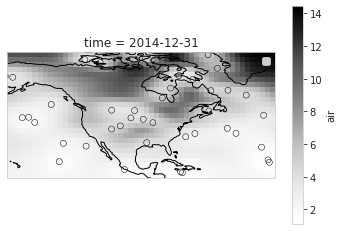

In [57]:
print(std_ds)
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=crs))
std_ds.isel(time=0).air.plot(cmap='Greys')
ax.coastlines()
deepsensor.plot.offgrid_context(ax, test_task, data_processor, task_loader, linewidths=0.5)

### Targets at off-grid points: Predict directly to pandas

In [58]:
# Predict at New York, San Francisco, and Seattle with 40 random (fixed) context points
X_t = np.array([[40.7128, 360-74.0060], [37.7749, 360-122.4194], [47.6062, 360-122.3321]]).T
test_tasks = task_loader(pd.date_range("2014-12-01", "2014-12-31"), 40, seed_override=42)

In [59]:
mean_df, std_df = model.predict(test_tasks, X_t=X_t, append_indexes={"loc": ["new_york", "san_francisco", "seattle"]})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


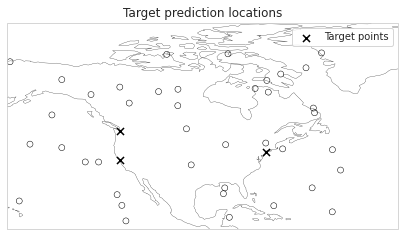

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw=dict(projection=crs))
extent = [ds_raw["lon"].min(), ds_raw["lon"].max(), ds_raw["lat"].min(), ds_raw["lat"].max()]
ax.set_extent(extent)
ax.coastlines(linewidth=0.25)
deepsensor.plot.offgrid_context(ax, test_tasks[0], data_processor, task_loader, linewidths=0.5)
ax.scatter(X_t[1, :], X_t[0, :], marker="x", color="black", s=50, label="Target points")
ax.legend()
ax.set_title("Target prediction locations")
plt.show()

/tmp/ipykernel_375298/3059797121.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


                                                  air
time       lat     lon      loc                      
2014-12-01 40.7128 285.9940 new_york       281.918213
           37.7749 237.5806 san_francisco  290.097778
           47.6062 237.6679 seattle        273.241058
2014-12-02 40.7128 285.9940 new_york       276.951599
           37.7749 237.5806 san_francisco  289.689056
...                                               ...
2014-12-30 37.7749 237.5806 san_francisco  286.199524
           47.6062 237.6679 seattle        271.938171
2014-12-31 40.7128 285.9940 new_york       266.315735
           37.7749 237.5806 san_francisco  284.852631
           47.6062 237.6679 seattle        275.660767

[93 rows x 1 columns]


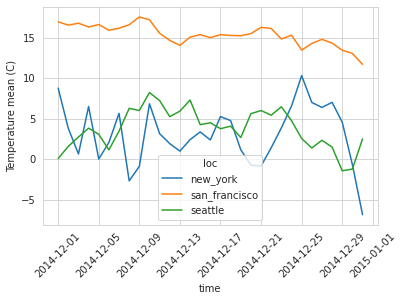

In [61]:
print(mean_df)
ax = sns.lineplot(data=mean_df-273.15, x="time", y="air", hue="loc")
ax.set_ylabel("Temperature mean (C)")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

                                                air
time       lat     lon      loc                    
2014-12-01 40.7128 285.9940 new_york        2.89674
           37.7749 237.5806 san_francisco  3.206859
           47.6062 237.6679 seattle        6.841148
2014-12-02 40.7128 285.9940 new_york       3.376093
           37.7749 237.5806 san_francisco  3.203519
...                                             ...
2014-12-30 37.7749 237.5806 san_francisco  3.473679
           47.6062 237.6679 seattle        6.911682
2014-12-31 40.7128 285.9940 new_york       4.567311
           37.7749 237.5806 san_francisco  3.569277
           47.6062 237.6679 seattle          6.0826

[93 rows x 1 columns]


/tmp/ipykernel_375298/819664832.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


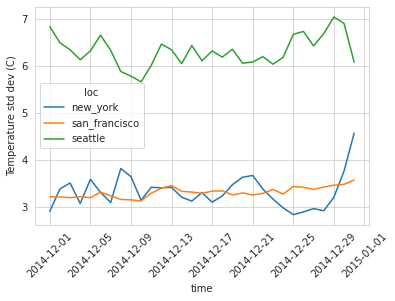

In [62]:
print(std_df)
ax = sns.lineplot(data=std_df, x="time", y="air", hue="loc")
ax.set_ylabel("Temperature std dev (C)")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

## Perform active learning

Use a greedy algorithm to propose locations for new context points.
Here we'll use the model 's standard deviation at search points as the acquisition function. Maximising this acquisition function will place context points at locations where the model is most uncertain.

In [63]:
greedy_alg = GreedyAlgorithm(
    model=model,
    X_t=ds_raw,
    X_s=ds_raw,
    N_new_context=10,
)

test_task = task_loader("2014-12-31", 20)
acquisition_fn = Stddev(model)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, test_task, "max")

In [64]:
X_new_df

,lat,lon
iteration,,
0,75.0,307.5
1,75.0,272.5
2,75.0,330.0
3,57.5,295.0
4,67.5,295.0
5,57.5,317.5
6,75.0,290.0
7,67.5,312.5
8,75.0,200.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


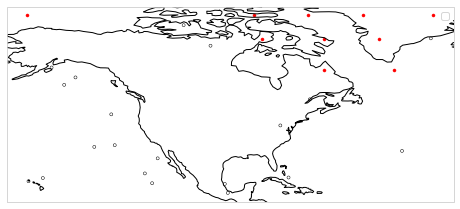

In [65]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
fig = deepsensor.plot.placements(test_task, X_new_df, data_processor, crs, figsize=8)